# LightGBM Stock/EFT Forecasting
## (Supplementary Notebook)
Compiled by Leo R. De Velez

This supplementary notebook applies the methodology used in the M5 Forecasting notebook, the LightGBM, on stocks and eft time series. In this supplementary notebook, we will be forecasting the Google (GOOG) stock price for the next 23 trading days starting November 14, 2022.
<br><br>
An earlier version of this Supplementary Notebook was used by Leo R. De Velez to participant in the 10th Month of the M6 Competition.  This latest version will be used to submit revised Stock/EFT positions for the 11th Month of the M6 Competition.
<br><br>
Most of the codes on this supplementary notebook  were copied from the previous notebook of this chapter, the "Winningest Methods in Time Series Forecasting", that was compiled by Sebastian C. Ibañez. 
<br><br>
Some of the codes from the previous notebook were removed, replaced, or modified and some new codes were added as needed by Leo R. De Velez.

## 1. Import the Python Modules

Import the necessary python modules.

In [162]:
## Copied from previous notebook and modified as needed

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import MultiOutputRegressor

import yfinance as yf

## 2. Load the Stock/EFT Dataset

Read and load the Stock/EFT Dataset.

Below are the Stocks/EFTs Ticker Names that are included in the M6 Competition:

ABBV,ACN,AEP,AIZ,ALLE,AMAT,AMP,AMZN,AVB,AVY,AXP,BDX,BF-B,BMY,BR,CARR,CDW,CE,CHTR,CNC,CNP,COP,
CTAS,CZR,DG,DPZ,DRE,DXC,META,FTV,GOOG,GPC,HIG,HST,JPM,KR,OGN,PG,PPL,PRU,PYPL,RE,ROL,ROST,UNH,
URI,V,VRSK,WRK,XOM,
IVV,IWM,EWU,EWG,EWL,EWQ,IEUS,EWJ,EWT,MCHI,INDA,EWY,EWA,EWH,EWZ,EWC,IEMG,LQD,HYG,SHY,IEF,TLT,
SEGA.L,IEAA.L,HIGH.L,JPEA.L,IAU,SLV,GSG,REET,ICLN,IXN,IGF,IUVL.L,IUMO.L,SPMV.L,IEVL.L,IEFM.L,
MVEU.L,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLU,XLP,XLB,VXX

In this Supplementary Notebook, we will look at the Google Stock (GOOG).

In [163]:
ticker = 'GOOG'
filename = ticker+'.csv'
startdate = '2012-01-31'
enddate = '2022-11-11'
df = yf.download(ticker, start=startdate, end=enddate)
df.to_csv(filename)

[*********************100%***********************]  1 of 1 completed


In [164]:
df = pd.read_csv(filename, index_col='Date')
df = df.dropna()

## 3. Examine the Dataset

Print and plot the dataset.

<bound method NDFrame.head of                 Close
Date                 
2012-01-31  14.448593
2012-02-01  14.466526
2012-02-02  14.573126
2012-02-03  14.852579
2012-02-06  15.170388
...               ...
2022-11-04  86.699997
2022-11-07  88.650002
2022-11-08  88.910004
2022-11-09  87.400002
2022-11-10  94.169998

[2715 rows x 1 columns]>
Index(['2012-01-31', '2012-02-01', '2012-02-02', '2012-02-03', '2012-02-06',
       '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10', '2012-02-13',
       ...
       '2022-10-28', '2022-10-31', '2022-11-01', '2022-11-02', '2022-11-03',
       '2022-11-04', '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10'],
      dtype='object', name='Date', length=2715)


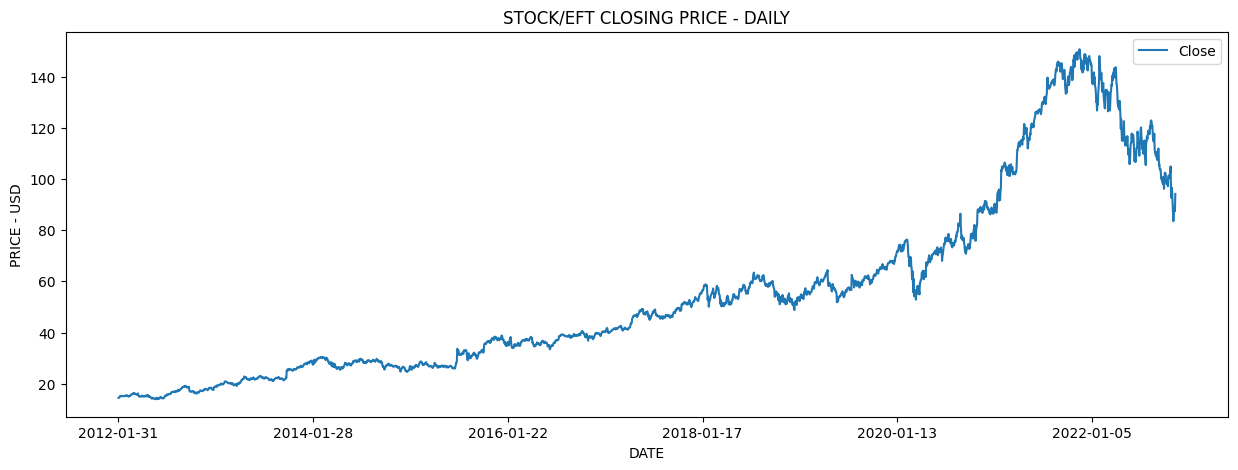

In [165]:
## Copied from previous notebook and modified as needed

series = pd.DataFrame(df['Close'])
print(series.head)
print(series.index)

plt.rcParams['figure.figsize'] = [15, 5]
np.set_printoptions(precision = 6, suppress = True)
series.plot()
plt.title("STOCK/EFT CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 4. Define the Data Preparation

Define the procedure for slicing the datasets into arrays of Independent and Dependent Variables.

In [166]:
## Copied from previous notebook and modified as needed

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

## 5. Prepare the Training, Validation, and Testing Datasets

Split the x and y arrays into training, validation, and testing datasets

In [167]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 45
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size - window_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2602, 45)
(2602,)
(23, 45)
(23,)


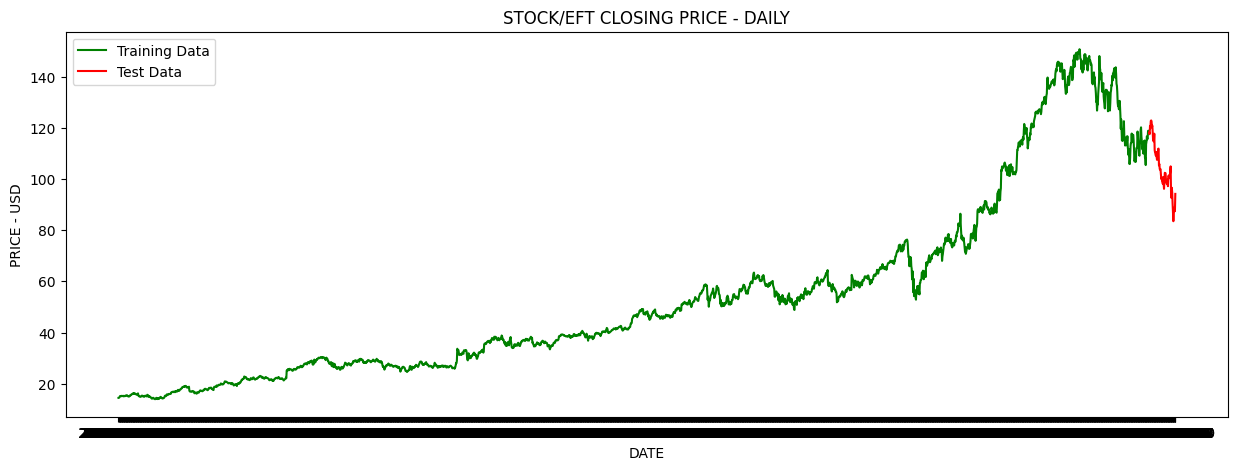

In [168]:
## Show the split of data from training, validation, and testing.

plt.plot(train_series, color='green', label = 'Training Data')
plt.plot(test_series, color='red', label = 'Test Data')
plt.title("STOCK/EFT CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 6. Build the LightGBM Model

In [169]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

## 7. Forecast and Compare with Test Data

In [170]:
## Check the forecasting accuracy of LightGBM

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 2.9379
  LightGBM MAPE : 3.1237
  LightGBM RMSE : 3.6817


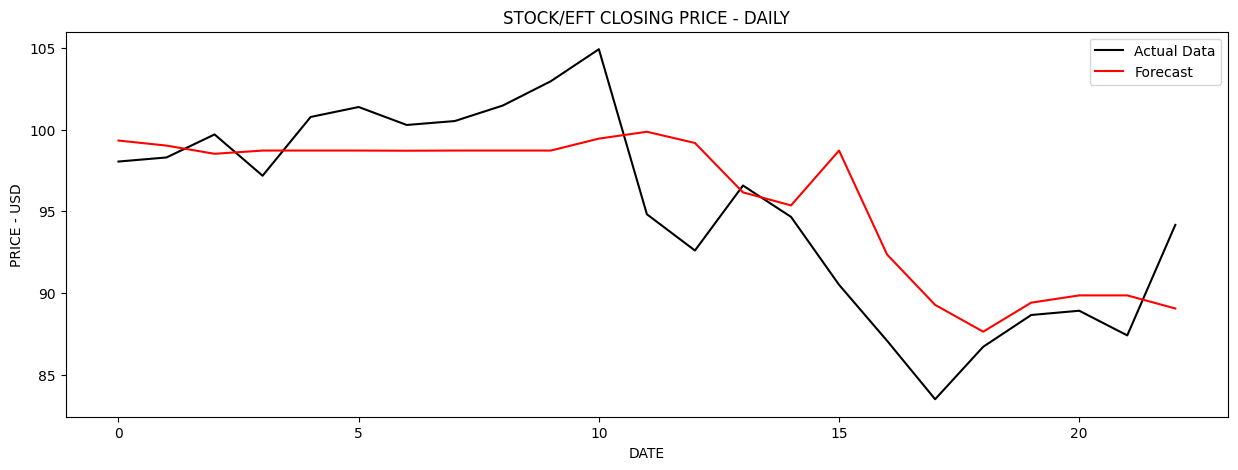

In [171]:
## Graphically compare the forecast vs actual data.

plt.plot(test_y, color='black', label = 'Actual Data')
plt.plot(forecast, color='red', label = 'Forecast')
plt.title("STOCK/EFT CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 8. Compare Forecast Accuracy with Benchmarks

Compare the forecasting accuracy of the LightGBM with Naive and Seasonal Naive.
<br>
The LightGBM forecast output was based on the text_x dataset input.
<br>
The LightGBM forecast output was compared with the text_y actual data.
<br>
The errors were computed as MAE and MAPE.  These were compared with the benchmarks,

In [172]:
## Copied from previous notebook and modified as needed

s1_naive = series[-24:-1].to_numpy()
s7_naive = series[-30:-7].to_numpy()
s30_naive = series[-51:-28].to_numpy()
s365_naive = series[-359:-336].to_numpy()
s20_naive = series[-43:-10].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print(' s20-Naive MAE: %.4f' % (np.mean(np.abs(s20_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('')
print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print(' s20-Naive MAPE: %.4f' % (np.mean(np.abs(s20_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 6.7626
  s7-Naive MAE: 6.1523
 s30-Naive MAE: 9.5996
s365-Naive MAE: 32.3579
 s20-Naive MAE: 6.5925
  LightGBM MAE: 2.9379

     Naive MAPE: 7.1933
  s7-Naive MAPE: 6.7164
 s30-Naive MAPE: 10.4585
s365-Naive MAPE: 34.5004
 s20-Naive MAPE: 7.2406
  LightGBM MAPE: 3.1237


## 9. Tune the LightGBM Hyperparameters

Determine the best window setting for the LightGBM model.

  5 --- MAE: -3.996 (0.146)
 10 --- MAE: -4.002 (0.150)
 15 --- MAE: -4.005 (0.150)
 20 --- MAE: -4.014 (0.145)
 23 --- MAE: -4.016 (0.163)
 30 --- MAE: -4.018 (0.201)
 45 --- MAE: -4.037 (0.191)
 90 --- MAE: -4.093 (0.186)
180 --- MAE: -4.194 (0.164)
365 --- MAE: -4.413 (0.173)


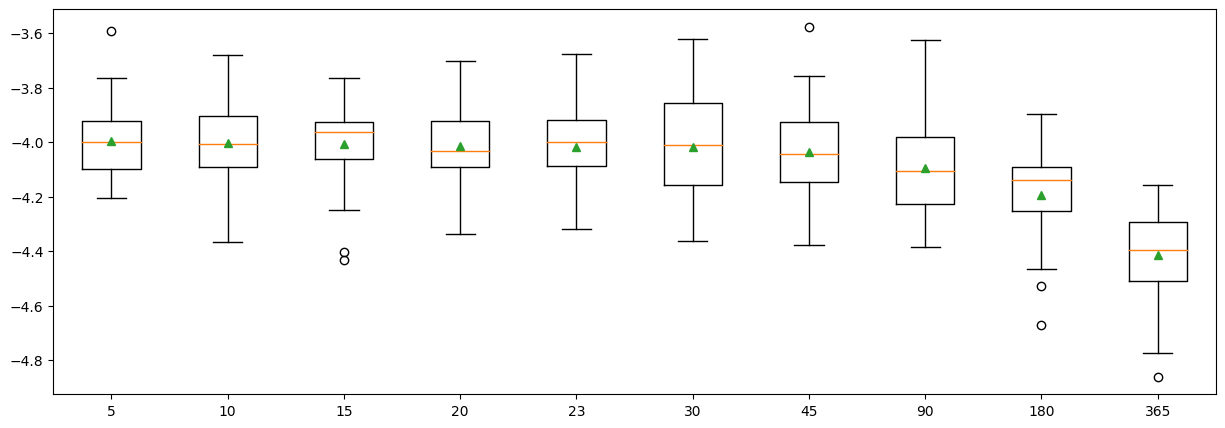

In [173]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}
windows = [5, 10, 15, 20, 23, 30, 45, 90, 180, 365]
results = []
names = []
for w in windows:
    window_size = w
    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
    train_y = train_y.flatten()
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [15, 5]    
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## 10. Adjust the Hyperparameters

Use the window size that produced the lowest Mean Absolute Error. Compare the resulting MAE.

In [174]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 45
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
#test_size = int(len(series)*0.2)
test_size = 23
split_time = len(series) - test_size - window_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2602, 45)
(2602,)
(23, 45)
(23,)


## 11. Re-Build the LightGBM 

In [175]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

## 12. Re-Forecast and Compare

In [176]:
## Re-Run the prediction model and check the resulting forecasting accuracy

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 2.9379
  LightGBM MAPE : 3.1237
  LightGBM RMSE : 3.6817


The LightRBM Mean Absolute Percent Error improved only a bit from about 18.25% down to about 17.27%.

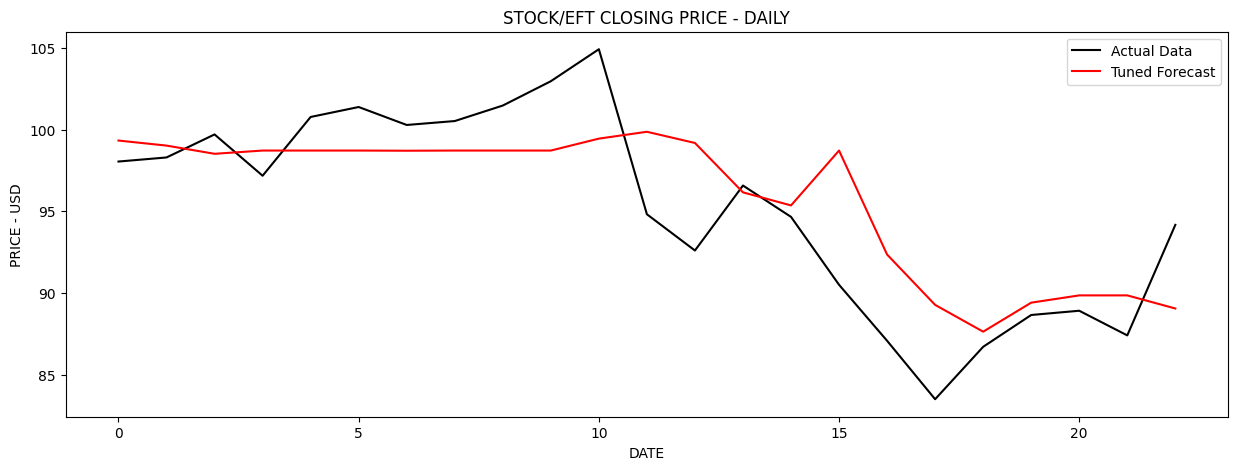

In [177]:
## Graphically compare the forecast vs actual data.

plt.plot(test_y, color='black', label = 'Actual Data')
plt.plot(forecast, color='red', label = 'Tuned Forecast')
plt.title("STOCK/EFT CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

In [178]:
print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print(' s20-Naive MAE: %.4f' % (np.mean(np.abs(s20_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('')
print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print(' s20-Naive MAPE: %.4f' % (np.mean(np.abs(s20_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 6.7626
  s7-Naive MAE: 6.1523
 s30-Naive MAE: 9.5996
s365-Naive MAE: 32.3579
 s20-Naive MAE: 6.5925
  LightGBM MAE: 2.9379

     Naive MAPE: 7.1933
  s7-Naive MAPE: 6.7164
 s30-Naive MAPE: 10.4585
s365-Naive MAPE: 34.5004
 s20-Naive MAPE: 7.2406
  LightGBM MAPE: 3.1237


## 13. Recursive Forecasting

Recursive Forecasting n-periods

In [179]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 20
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 23
split_time = len(series) - test_size - window_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2652, 20)
(2652,)
(23, 20)
(23,)


In [180]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

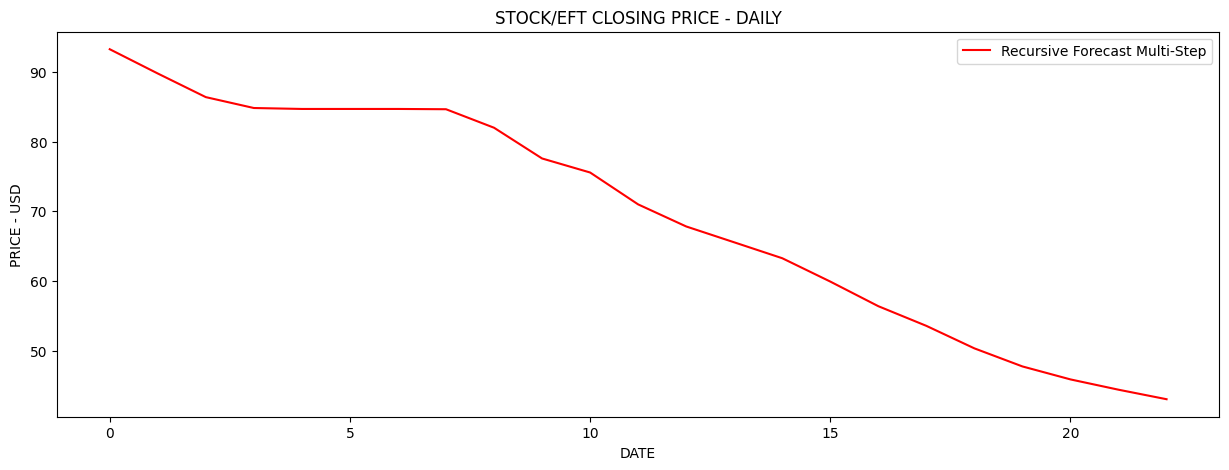

In [181]:
## Copied from previous notebook and modified as needed

recursive_x = test_x[0, -window_size:]

forecast_ms = []
#for i in range(test_x.shape[0]):
for i in range(test_size):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()

plt.plot(forecast_ms_rec, color='red', label = 'Recursive Forecast Multi-Step')
plt.title("STOCK/EFT CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 14. Direct Forecasting

Direct Forecasting n-periods.

In [182]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 20
prediction_horizon = 23

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 23
split_time = len(series) - test_size - window_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(2630, 20)
(2630, 23)
(1, 20)
(1, 23)


In [183]:
## Copied from previous notebook and modified as needed

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

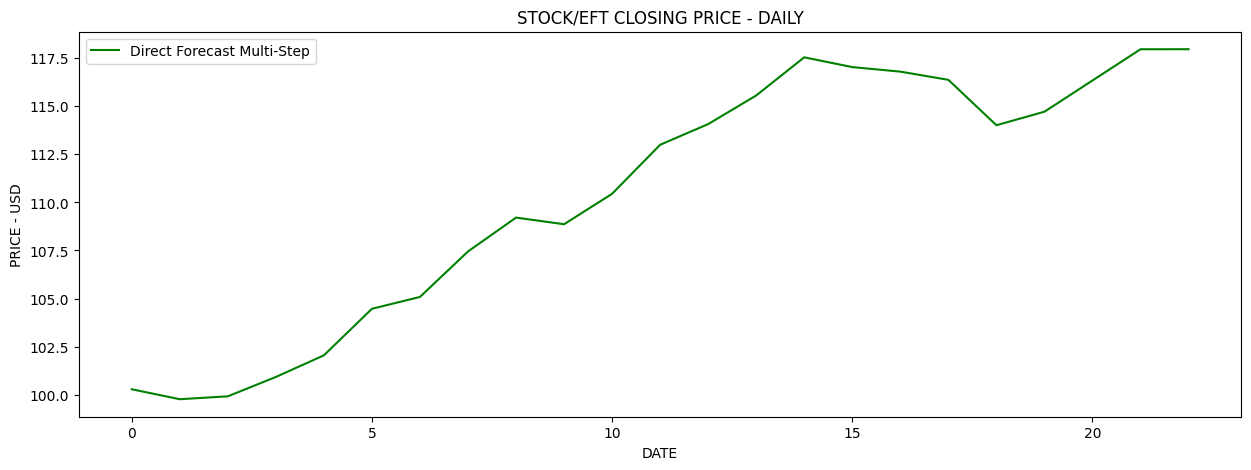

In [184]:
## Copied from previous notebook and modified as needed

forecast_ms_dir = model.predict(test_x[-window_size:])

plt.plot(forecast_ms_dir.flatten(), color='green', label = 'Direct Forecast Multi-Step')
#plt.plot(forecast_os[-30:], color='blue', label = 'Forecast One-Step')
plt.title("STOCK/EFT CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()


## 15. Combined Forecasting

Combining Recursive and Direct Forecast with equal weights.

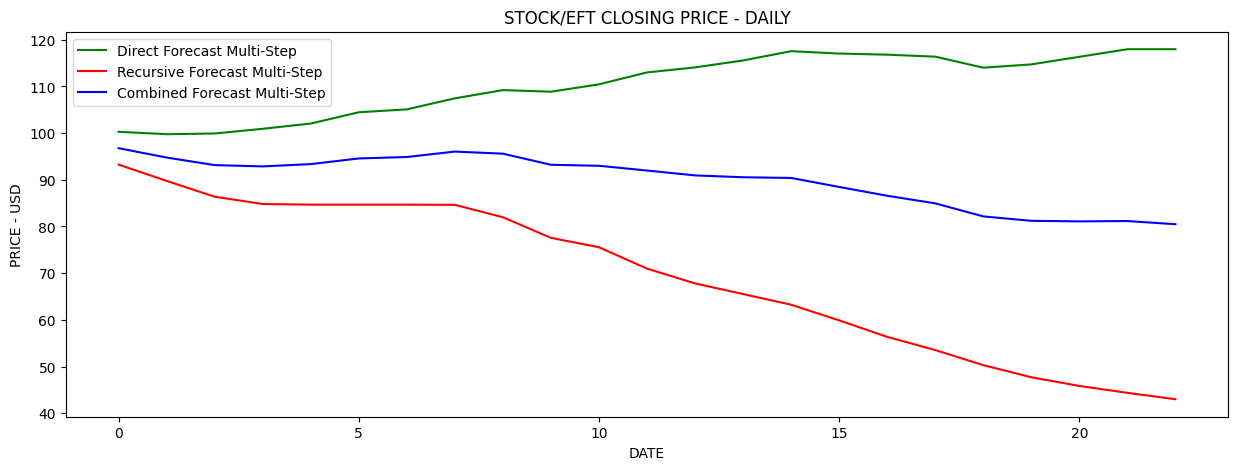

In [185]:
## Copied from previous notebook and modified as needed

forecast_ms_comb = 0.5*forecast_ms_dir.flatten() + 0.5*forecast_ms_rec

plt.plot(forecast_ms_dir.flatten(), color='green', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_rec, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_ms_comb, color='blue', label = 'Combined Forecast Multi-Step')
plt.title("STOCK/EFT CLOSING PRICE - DAILY")
plt.xlabel("DATE")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 16. Compare with the latest Stock Prices

[*********************100%***********************]  1 of 1 completed
  LightGBM MAE  : 3.4469
  LightGBM MAPE : 3.5234
  LightGBM RMSE : 3.8651


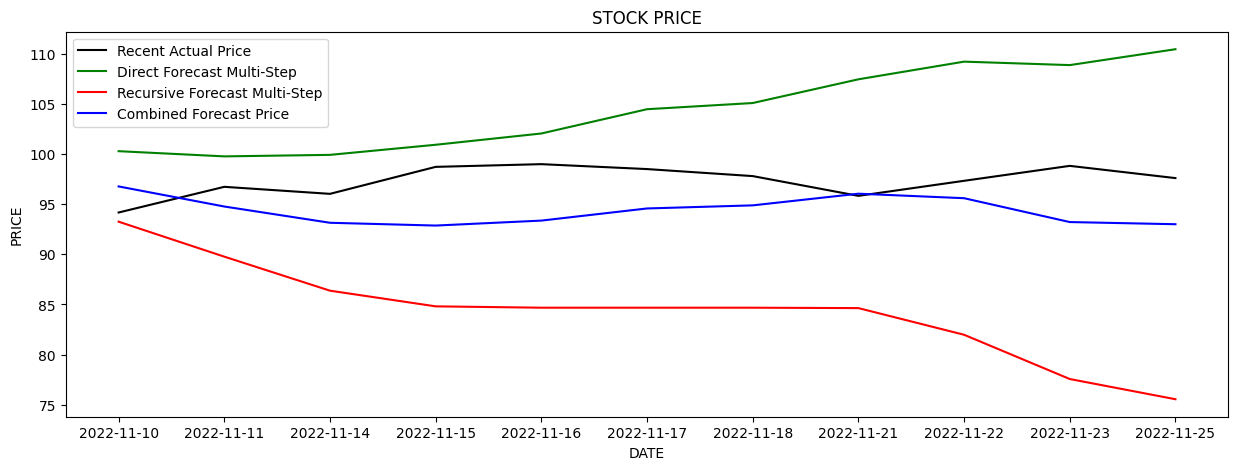

In [186]:
ticker = 'GOOG'
filename_new = ticker+'_new.csv'
startdate = '2022-11-10'
ticker_data = yf.download(ticker, start=startdate)
ticker_data.to_csv(filename_new)

df = pd.read_csv(filename_new,
    index_col='Date')
df = df.dropna()
series_latest = pd.DataFrame(df['Close'])

latest_len = len(series_latest)
forecast_ms_comb_latest = forecast_ms_comb[0:latest_len]
#forecast_ms_dir_latest = forecast_ms_dir[0:latest_len]
forecast_ms_rec_latest = forecast_ms_rec[0:latest_len]

print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast_ms_comb_latest - series_latest['Close'].values))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast_ms_comb_latest - series_latest['Close'].values)/series_latest['Close'].values*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast_ms_comb_latest - series_latest['Close'].values)**2))))

plt.plot(series_latest, color='black', label = 'Recent Actual Price')
plt.plot(forecast_ms_dir_latest.flatten()[:latest_len], color='green', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_rec_latest, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_ms_comb_latest, color='blue', label = 'Combined Forecast Price')
plt.title("STOCK PRICE")
plt.xlabel("DATE")
plt.ylabel("PRICE")
plt.legend()
plt.show()

## 17. Feature Importance

Generate the feature importance metrics.

In [187]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 20
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 23
split_time = len(series) - test_size - window_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          feature_name = feature_name_list,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

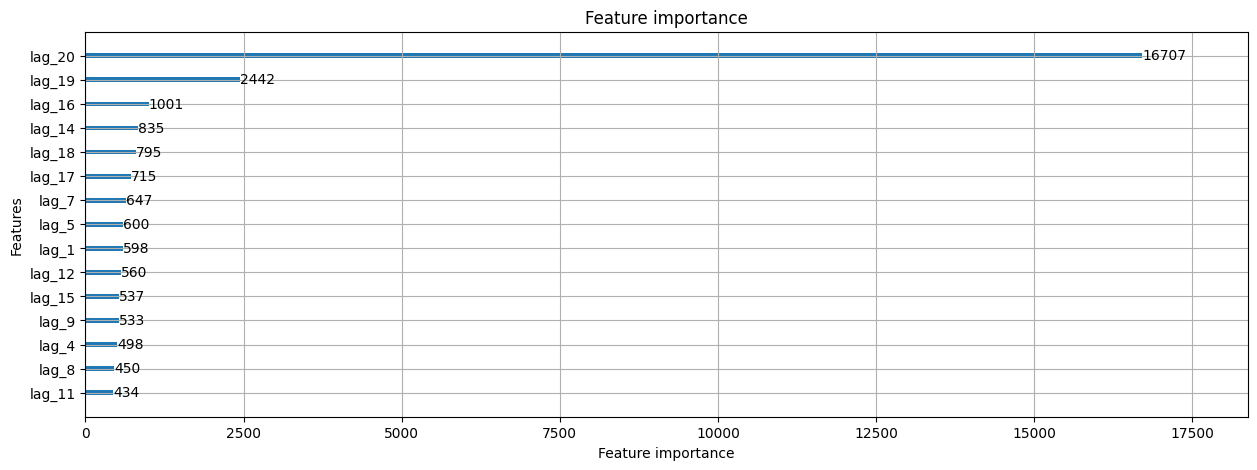

In [188]:
## Copied from previous notebook and modified as needed

lgb.plot_importance(model, max_num_features = 15, importance_type = 'split')
plt.show()

## 18. Summary

In summary, this supplementary notebook demonstrated how to use the LightGBM, that was used by the winning team in the M5 Forecasting Competiton, for forecasting the Google (GOOG) stock price as part of the inputs to the participant's entry to the 10th Month of the M6 Competition.

The forecasting accuracy of the LighgGBM model used for forecasting the Google (GOOG) stock price was compared with Naive and Seasonal Naive forecast outputs.  Based on the comparison, the LightGMB forecasting accuracy for the Google stock price was significantly better. The forecasting accuracy of the LightGBM for the 10th Month Google stock price dataset is at around 3.1% Mean Absolute Percentage Error (MAPE) compared with the MAPE Naive and sNaive benchmarks for the same dataset of about about 6.7% MAPE.

The tuning of the LightGBM model worsen its forecasting accuracy.  From about 3% MAPE, it worsen to about 6% MAPE, which was not far from the forecasting accuracy of Naive and sNaive.

However, when tested with the latest actual stock prices of Google (GOOG), the forecasting accuracy of the tuned LightGBM showed about 3.5% MAPE.

Since the actual stock prices is relatively flat, the forecasting accuracy of the LightGBM for Google Stock price in the near future will not be significantly better than the Naive forecast.


## 19. References

[1] S. Makridakis, E. Spiliotis, and V. Assimakopoulos. The M5 Accuracy competition: Results, findings and conlusions. 2020.

[2] S. Makridakis, E. Spiliotis, V. Assimakopoulos, Z. Chen, A. Gaba, I. Tsetlin, and R. Winkler. The M5 Uncertainty competition: Results, findings and conlusions. 2020.

[3] V. Jose, and R. Winkler. Evaluating quantile assessments. Operations research, 2009.

[4] A. Gaba, I. Tsetlin, and R. Winkler. Combining interval forecasts. Decision Analysis, 2017.